# Bloby Usage Example

Bloby is an end-to-end package

* detect blobs from a 3D TIF stack
* quantitatively evaluate detection results and 
* upload the results to BOSS for qualitative visualization

This Jupyter Notebook will explain how to use each section of this package's pipeline.

## 1. Blob Detection

The blob detection part of the pipeline uses Gaussian Mixture Model (GMM) clustering for thresholding, followed by morphological erosion and then finally finds centroids using connected components. The below snippet shows how to instantiate the _Bloby_ class and find blobs from a TIF stack. 

**Note**: Initial current implementation of the package asks the user for the number of components for GMM.

In [1]:
from src.BlobDetector import BlobDetector
from src import util

exp_name = 'cell_detection_0'
input_tif_path = 'data/s3617/tifs/sample.tiff'.format(exp_name)
output_csv_path = 'data/s3617/prediction_csv/{}.csv'.format(exp_name)

detector = BlobDetector(input_tif_path, n_components=2)
centroids = detector.get_blob_centroids()
util.write_list_to_csv(centroids, output_csv_path) #writing the detection output to CSV in (z,y,x) format

### Viewing the output CSV

In [2]:
centroid_list = util.get_list_from_csv(output_csv_path)
for centroid in centroid_list[:5]: #sample rows
    print(centroid)
print('...')

[4.0, 446.0, 496.0]
[12.0, 248.0, 456.0]
[12.0, 434.0, 498.0]
[14.0, 372.0, 460.0]
[20.0, 246.0, 458.0]
...


## 2. Quantitative Evaluation - _BlobMetrics_ class

The _BlobMetrics_ class which is a part of this package, can be used to evaluate Quantitatively the blob detection results, given a manually annotated ground truth CSV.

In [3]:
from src.BlobMetrics import BlobMetrics

ground_truth_path = 'data/s3617/annotations/{}.csv'.format(exp_name)
ground_truth = util.get_list_from_csv(ground_truth_path)

metrics = BlobMetrics(ground_truth, centroids, euclidean_distance_threshold=12)
print('Precision: {}\nRecall: {}'.format(metrics.precision(), metrics.recall()))

Precision: 0.619
Recall: 0.897


Apart from numerical metrics, we can evaluate the prediction based on the following two plots

### Number of predictions per ground truth label

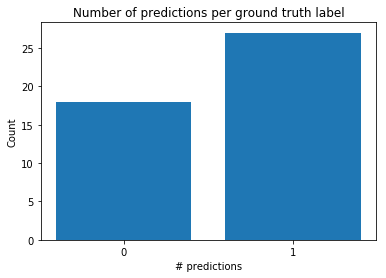

In [4]:
metrics.plot_predictions_per_ground_truth()

### Number of ground truth labels per prediction

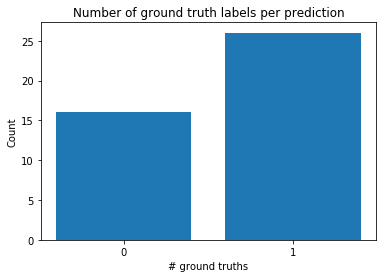

In [5]:
metrics.plot_ground_truths_per_prediction()

## 3. Qualitative evaluation - BOSS Upload

In order to visualize the prediction results, the package supports BOSS upload

**Step 1**: First we need to plot the prediction results in an empty TIF stack

In [6]:
output_tif_path = 'data/s3617/prediction_tifs/{}.tiff'.format(exp_name)
util.plot_csv_on_tif(centroids, input_tif_path, output_tif_path)

**Step 2**: Create config params - The BOSS upload needs certain parameters to be configured. It can be done as follows. _intern.cfg_ should be in the following format

```
protocol = https
host = api.boss.neurodata.io
token = <your_boss_api_token>
```

In [7]:
from src.IngestTifStack import ConfigParams
util.create_intern_config()

ingest_conf = {
    'collection': 'cell_detection',
    'experiment': exp_name,
    'channel': 'docker_test',
    'tif_stack': 'data/s3617/prediction_tifs/{}.tiff'.format(exp_name),
    'type': 'annotation',
    'new_channel': True,
    'source_channel': 'raw_data',
    'config': 'intern.cfg'
}
params = ConfigParams(ingest_conf)

**Step 3**: Upload it to BOSS. The following code uploads the specified TIF task to the specified collection/experiment/channel as a new _annotation_ channel which is sourced to the **raw_data** channel.

In [8]:
from src.IngestTifStack import IngestTifStack

group_name = 'ndd17_claritrons' 
#optional parameter if you want to grant permissions to the new channel that you have created

ingest = IngestTifStack(params)
upload_link = ingest.start_upload(group_name=group_name)
print('Results uploaded to {}'.format(upload_link))

Results uploaded to https://ndwebtools.neurodata.io/ndviz_url/cell_detection/cell_detection_0/
